In [ ]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from ukbb_recessive.regression.regressions import read_results_excel
import ukbb_recessive.regression.plotting as plotting
from matplotlib.cm import get_cmap


sns.set_style("whitegrid")

# Add fonts
plotting.add_fonts(['../../../data/fonts'])
plotting.configure_matplotlib()

PLOTS_OUTPUT_DIR = '../../../data/plots'
tables_folder = '../../../data/tables'

# Prepare datasets

## Load sex-specific analysis

In [3]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

results_path = f"{tables_folder}/table_sex_specific_analysis.xlsx"

# load flat table
sex_specific = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
sex_specific = sex_specific[sex_specific['feature'].str.contains("s_het")]

# add odds ratio distance
sex_specific = plotting.add_odds_ratio_intervals(sex_specific)
sex_specific = plotting.add_effect_size_intervals(sex_specific)

# select dataset
sex_specific = sex_specific[sex_specific['dataset'] == 'Roulette']
sex_specific['target'] = sex_specific['target'].apply(lambda x: renaming_dict_target.get(x, x))
sex_specific = sex_specific[sex_specific['analysis'] == 'basic_analysis']


# Plot

In [10]:
def plot_sex_specific(ax, dataset, targets, gender_order=['males', 'females'], 
                      plot_entity='odds_ratio', vline_loc=1, legend_loc='upper left'):

    legend_kwargs = {
        "bbox_to_anchor": (-0.5, 1.2, 1.2, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 2, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    colors = [ '#d43d51', '#094074',]
    
    plot_data = dataset[dataset['target'].isin(targets)].copy()

    plotted_data = plotting.plot_errorbar_grouped(df=plot_data, 
                                        axis=ax, 
                                        y_column='target', 
                                        group_column = 'gender',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.25, 
                                        y_scale=0.8,
                                        colors=colors,
                                        group_order=gender_order, 
                                        plot_entity=plot_entity, 
                                        vertical_loc=vline_loc, 
                                        horizontal=False)
    
    x_label = 'Effect size' if plot_entity == 'effect' else 'Odds ratio'
    
    plotting.configure_axis(ax, x_label=x_label, y_label=None,  format_x=True)

    # Display p-values or any other information in the sidebar
    odds_ratios = plotted_data[f'odds_ratio_pretty']
    p_values = plotted_data['p_value_corrected_pretty']
    positions = plotted_data['y']

    plot_loc = plotted_data[f'{plot_entity}'] - plotted_data[f'{plot_entity}_lower_distance']

    for i, (loc, eff, p, pos) in enumerate(zip(plot_loc, odds_ratios, p_values, positions)):
        ax.text(loc+0.1, pos+0.005, f'{eff}, P = {p}', va='center', size=plotting.SMALL_SIZE)

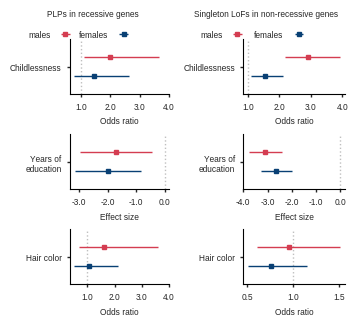

In [14]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(8.8*cm*k, 8*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=2,  width_ratios=[1, 1], wspace=0.0)

# plot phenotypes results
ax_left = subfigs[0].subplots(3, 1)
df = sex_specific[sex_specific['feature'] == 's_het_recessive_all'].copy()
plot_sex_specific(ax_left[0], dataset=df, targets = ['Childlessness'], plot_entity='odds_ratio', vline_loc=1)
ax_left[0].set_xticks([1., 2., 3., 4.])
ax_left[0].set_xticklabels([1., 2., 3., 4.])
plot_sex_specific(ax_left[1], dataset=df, targets = ['Years of\neducation'], plot_entity='effect', vline_loc=0, legend_loc=None)
ax_left[1].set_xticks([-3., -2., -1., 0.])
ax_left[1].set_xticklabels([-3., -2., -1., 0.])
plot_sex_specific(ax_left[2], dataset=df, targets = ['Hair color'], plot_entity='odds_ratio', vline_loc=1, legend_loc=None)
ax_left[2].set_xticks([1., 2., 3., 4.])
ax_left[2].set_xticklabels([1., 2., 3., 4.])

plotting.configure_axis(ax_left[0], x_label='Odds ratio',  xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_left[1], x_label='Effect size', xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_left[2], x_label='Odds ratio', xlim=None, ymargin=0.9, format_x=True)
subfigs[0].suptitle('PLPs in recessive genes', size=plotting.MEDIUM_SIZE)

# plot synonymous
ax_right = subfigs[1].subplots(3, 1)
df = sex_specific[sex_specific['feature'] == 's_het_lof_without_AR'].copy()
plot_sex_specific(ax_right[0], dataset=df, targets = ['Childlessness'], plot_entity='odds_ratio', vline_loc=1)
plot_sex_specific(ax_right[1], dataset=df, targets = ['Years of\neducation'], plot_entity='effect', vline_loc=0, legend_loc=None)
ax_right[1].set_xticks([-4., -3., -2., -1., 0.])
ax_right[1].set_xticklabels([-4., -3., -2., -1., 0.])
plot_sex_specific(ax_right[2], dataset=df, targets = ['Hair color'], plot_entity='odds_ratio', vline_loc=1, legend_loc=None)

plotting.configure_axis(ax_right[0], x_label='Odds ratio',  xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_right[1], x_label='Effect size', xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_right[2], x_label='Odds ratio', xlim=None, ymargin=0.9, format_x=True)
subfigs[1].suptitle('Singleton LoFs in non-recessive genes', size=plotting.MEDIUM_SIZE)

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/figure_5.pdf", format="pdf", bbox_inches="tight")